In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import IPython.display as disp
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import transforms
from vector_quantize_pytorch import FSQ

In [2]:
dataset = load_dataset("danjacobellis/vimeo90k_triplet",split='train').with_format("torch")
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

Resolving data files:   0%|          | 0/71 [00:00<?, ?it/s]

In [3]:
from vector_quantize_pytorch import FSQ

class VectorQuantizedAutoencoder(nn.Module):
    def __init__(self, levels):  # Provide levels as an argument
        super().__init__()
        self.layers = nn.ModuleList(
            [
                nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.GELU(),
                nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                nn.MaxPool2d(kernel_size=2, stride=2),
                FSQ(levels),  # Use FSQ instead of VectorQuantize
                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                nn.GELU(),
                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.Conv2d(128, 3, kernel_size=3, stride=1, padding=1),
            ]
        )
        return

    def forward(self, x):
        indices = None  # Initialize indices
        for layer in self.layers:
            if isinstance(layer, FSQ):
                x_shape = x.shape[:-1]
                x_flat = x.reshape(x.size(0), -1, x.size(1))
                x_flat, indices = layer(x_flat)  # FSQ does not return commit_loss
                x = x_flat.reshape(*x_shape, -1)
            else:
                x = layer(x)
        return x.clamp(-1, 1), indices  # commit_loss is not returned

In [4]:
def live_plot(x):
    plt.clf()
    plt.plot(x)
    disp.display(plt.gcf())
    disp.clear_output(wait=True)

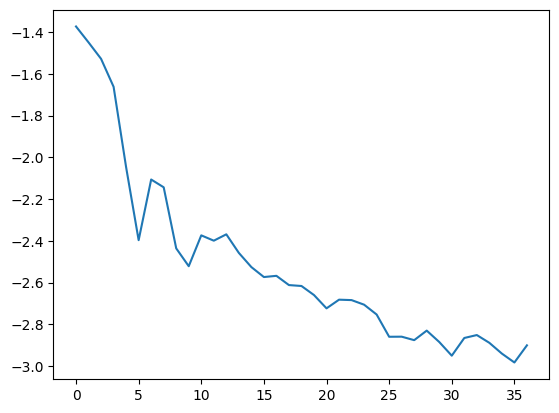

In [ ]:
lr = 3e-4
seed = 1234
alpha=10
levels = [8] * 128
torch.random.manual_seed(seed)
model = VectorQuantizedAutoencoder(levels).to("cuda")
opt = torch.optim.AdamW(model.parameters(), lr=lr)

log_loss = np.array([])
for i_epoch in range(5):
    for i_batch, batch in enumerate(dataloader):
        x = batch['image'].to("cuda")
        x = x.to(torch.float)
        x = x/255
        x = x - 0.5
        x = x.permute(0, 3, 1, 2)
        opt.zero_grad()
        out, indices = model(x)
        rec_loss = (out - x).abs().mean()
        rec_loss.backward()
        opt.step()
        log_loss = np.append(log_loss,np.log(rec_loss.detach().cpu().numpy()))
        live_plot(log_loss)
        torch.save({
            'epoch': i_epoch,
            'model_state_dict':  model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'log_loss': log_loss,
        }, f"vqvae_vimeo_checkpoint.pth")